# Market Simulation

This notebook creates one file.
For a given number of market situations, each market situation is simulated with the same starting condition multiple times for a specified time horizon.
In the `demand_learning_data` file we save explanatory variables for market situations and whether there was a purchase in the current situation. We also create three graphs displaying a selected time period from our simulation.

** We create the output files for three different pricing strategies:**
* _Strategy 1 (S1):_  For the watched company we chose a random price between 0 and 15. For all the other companies, we chose a price between 5 and 15.
* _Strategy 2 (S2):_ For each company we use the same pricing strategy:  
```min_competitor_price = min(prices_companies)
if min_competitor_price < 5:
    10
else:
    max(4.9, (min_competitor_price - 0.5))
```
* _Strategy 3 (S3):_ For the first three companies we use the approach from Strategy 2, except with different thresholds. The last two companies have a fixed price of either 11 or 13.

In [1]:
import random
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
numberPlayers = 5
timeHorizon = 100
numberReactionEvents = timeHorizon + 100
meanDifferenceCustomerArrival = 1
numberCustomerEvents = int(timeHorizon / meanDifferenceCustomerArrival + 100)
iterateDifferentStart = 100
iterateSameStart = 1
companyToWatch = 0
currentLine = 0
strategies = ["S1","S2","S3"]
random.seed(12530586)

In [3]:
pricesCompanies = np.array([[round(random.uniform(6,16),2) for _ in range(numberPlayers)]for _ in range(iterateDifferentStart)])
qualityCompanies = np.array([[round(random.uniform(1,5)) for _ in range(numberPlayers)]for _ in range(iterateDifferentStart)])
ratingCompanies = np.array([[round(random.uniform(90,100),1) for _ in range(numberPlayers)]for _ in range(iterateDifferentStart)])

In [4]:
def calculateTimeOfAdjustmentsCompany(numberReactionEvent, company, timeBetweenMarketEvents):
    if numberReactionEvent==0:
        return(random.uniform(0,1)) 
    else: return(calculateTimeOfAdjustmentsCompany(numberReactionEvent-1, company, timeBetweenMarketEvents)+timeBetweenMarketEvents[company][numberReactionEvent])
    
def calculateTimeOfCustomerArrival(numberCustomerEvent, timeBetweenCustomerEvents):
    if numberCustomerEvent==0:
        return timeBetweenCustomerEvents[numberCustomerEvent]
    else:
        return(calculateTimeOfCustomerArrival(numberCustomerEvent-1, timeBetweenCustomerEvents) + timeBetweenCustomerEvents[numberCustomerEvent])

In [5]:
timeBetweenMarketEvents = np.array([[[[random.uniform(0.8, 1.2) if numberReactionEvents != 1 and k==companyToWatch else 1.1 for _ in range(numberReactionEvents)] for k in range(numberPlayers)]for s in range(iterateSameStart)]for d in range(iterateDifferentStart)])

timeOfAdjustmentsCompany = np.array([[[[calculateTimeOfAdjustmentsCompany(i, j, timeBetweenMarketEvents[d,s]) for i in range(numberReactionEvents)] for j in range(numberPlayers)]for s in range(iterateSameStart)]for d in range(iterateDifferentStart)])

priceAdjustmentsBeforeHorizon = np.array([[set([timeOfAdjustmentsCompany[d,s].flatten()[i] for i in range(len(timeOfAdjustmentsCompany[d,s].flatten())) if timeOfAdjustmentsCompany[d,s].flatten()[i] < timeHorizon])for s in range(iterateSameStart)]for d in range(iterateDifferentStart)])
for d in range(iterateDifferentStart):
    for s in range(iterateSameStart):
        priceAdjustmentsBeforeHorizon[d,s].add(timeHorizon)
priceAdjustmentsBeforeHorizon = np.array([[sorted(priceAdjustmentsBeforeHorizon[d,s])for s in range(iterateSameStart)]for d in range(iterateDifferentStart)])
numberPriceAdjustmentsBeforeHorizon = np.array([[len(priceAdjustmentsBeforeHorizon[d,s])for s in range(iterateSameStart)]for d in range(iterateDifferentStart)])

timePriceAdjustments = np.array([[[0 if i==0 else priceAdjustmentsBeforeHorizon[d,s][i-1] for i in range(numberPriceAdjustmentsBeforeHorizon[d,s]+1)]for s in range(iterateSameStart)]for d in range(iterateDifferentStart)])

# we have to be careful because of the first timeslot
timeBetweenAdjustments = np.array([[[timePriceAdjustments[d,s][i]-timePriceAdjustments[d,s][i-1] if i > 0 else timePriceAdjustments[d,s][i] for i in range(numberPriceAdjustmentsBeforeHorizon[d,s])]for s in range(iterateSameStart)]for d in range(iterateDifferentStart)])

timeBetweenCustomerEvents = np.array([[[meanDifferenceCustomerArrival*np.random.exponential() for _ in range(numberCustomerEvents)]for _ in range(iterateSameStart)]for _ in range(iterateDifferentStart)])

timeOfCustomerArrival = np.array([[[calculateTimeOfCustomerArrival(i, timeBetweenCustomerEvents[d,s]) for i in range(numberCustomerEvents)]for s in range(iterateSameStart)]for d in range(iterateDifferentStart)])    
    
companyAdjustingAtTime = np.array([[[min(np.where(timeOfAdjustmentsCompany[d,s]==timePriceAdjustments[d,s][i])[0])if timePriceAdjustments[d,s][i]!=timeHorizon and i!=0 else -1  for i in range(numberPriceAdjustmentsBeforeHorizon[d,s]+1)]for s in range(iterateSameStart)]for d in range(iterateDifferentStart)])    

randomCustomerScoringQuality = np.array([[[random.uniform(0,1) for _ in range(numberCustomerEvents)]for s in range(iterateSameStart)]for d in range(iterateDifferentStart)])

randomCustomerScoringRating = np.array([[[random.uniform(0,0.5) for _ in range(numberCustomerEvents)]for s in range(iterateSameStart)]for d in range(iterateDifferentStart)])

In [6]:
watchedCompany = companyToWatch

countAdjustmentsWatchedCompany = np.array([[sum([1 for i in range(numberPriceAdjustmentsBeforeHorizon[d,s]) if companyAdjustingAtTime[d,s][i] == watchedCompany])+1 for s in range(iterateSameStart)] for d in range(iterateDifferentStart)])

timeAdjustmentsWatchedCompany = np.array([[[timePriceAdjustments[d,s][i] for i in range(numberPriceAdjustmentsBeforeHorizon[d,s]) if companyAdjustingAtTime[d,s][i] == watchedCompany]for s in range(iterateSameStart)] for d in range(iterateDifferentStart)])
np.array([[timeAdjustmentsWatchedCompany[d,s].insert(0,0) for s in range(iterateSameStart)] for d in range(iterateDifferentStart)])
np.array([[timeAdjustmentsWatchedCompany[d,s].extend([timeHorizon]) for s in range(iterateSameStart)] for d in range(iterateDifferentStart)])

timeBetweenAdjustmentsWatchedCompany = np.array([[[timeAdjustmentsWatchedCompany[d,s][i] - timeAdjustmentsWatchedCompany[d,s][i-1] for i in range(1, countAdjustmentsWatchedCompany[d,s])]for s in range(iterateSameStart)] for d in range(iterateDifferentStart)])

In [7]:
def price_if_smaller_else(price, price_smaller, else_min, prices_comp, c):
    return(price if min(prices_comp[comp] for comp in range(numberPlayers) if comp!=c)< price_smaller else round(min([max(else_min, prices_comp[company]-0.5) for company in range(numberPlayers) if company != c]),2))

s1 = {
        '0' : lambda pricesCompanies, c: round(random.uniform(0,15),2),
        '1' : lambda pricesCompanies, c: round(random.uniform(5,15),2),
        '2' : lambda pricesCompanies, c: round(random.uniform(5,15),2),
        '3' : lambda pricesCompanies, c: round(random.uniform(5,15),2),
        '4' : lambda pricesCompanies, c: round(random.uniform(5,15),2)
    }

s2 = {
        '0' : lambda pricesCompanies, c: price_if_smaller_else(10,5,4.9,pricesCompanies,c),
        '1' : lambda pricesCompanies, c: price_if_smaller_else(10,5,4.9,pricesCompanies,c),
        '2' : lambda pricesCompanies, c: price_if_smaller_else(10,5,4.9,pricesCompanies,c),
        '3' : lambda pricesCompanies, c: price_if_smaller_else(10,5,4.9,pricesCompanies,c),
        '4' : lambda pricesCompanies, c: price_if_smaller_else(10,5,4.9,pricesCompanies,c)
    }

s3 = {
        '0' : lambda pricesCompanies, c: price_if_smaller_else(10,5,4.9,pricesCompanies,c),
        '1' : lambda pricesCompanies, c: price_if_smaller_else(9,4,3.9,pricesCompanies,c),
        '2' : lambda pricesCompanies, c: price_if_smaller_else(12,6,5.9,pricesCompanies,c),
        '3' : lambda pricesCompanies, c: 11,
        '4' : lambda pricesCompanies, c: 13
    }

In [8]:
def explanatoryVariables(d, s, explanatoryVariable, countAdjustment, strat):
    return {
        '0' : 1,
        '1' : priceRanksFirm[strat,d,s][countAdjustment],
        '2' : 1 if priceRanksFirm[strat,d,s][countAdjustment]==1 else 0,
        '3' : qualityRanksFirm[d],
        '4' : ratingRanks[d,watchedCompany],
        '5' : pricesTracked[strat,d,s][countAdjustment][watchedCompany],
        '6' : pricesTracked[strat,d,s][countAdjustment][watchedCompany] - min([pricesTracked[strat,d,s][countAdjustment][j] for j in range(numberPlayers) if j!=watchedCompany]) if numberPlayers > 1 else 0,
        '7' : qualityCompanies[d,watchedCompany],
        '8' : ratingCompanies[d,watchedCompany],
        '9' : 15 - (pricesTracked[strat,d,s][countAdjustment][watchedCompany]+0.5*qualityCompanies[d,watchedCompany]+0.25*(100-ratingCompanies[d,watchedCompany])) if(
        (pricesTracked[strat,d,s][countAdjustment][watchedCompany]+0.5*qualityCompanies[d,watchedCompany]+0.25*(100-ratingCompanies[d,watchedCompany])) <
        min([pricesTracked[strat,d,s][countAdjustment][j] +0.5*qualityCompanies[d,j]+0.25*(100-ratingCompanies[d,j]) for j in range(numberPlayers) if j!= watchedCompany]))
        else 0,
    }[str(explanatoryVariable)]

def calculatePrices(pricesCompaniesAdjustments, adjustingFirm, strategy):
    for i in range(1,len(pricesCompaniesAdjustments)-1):        
        pricesCompaniesAdjustments[i][adjustingFirm[i]] = strategy[str(adjustingFirm[i])](pricesCompaniesAdjustments[i-1],adjustingFirm[i])
    pricesCompaniesAdjustments[len(pricesCompaniesAdjustments)-1] = pricesCompaniesAdjustments[len(pricesCompaniesAdjustments)-2]
    return pricesCompaniesAdjustments

In [9]:
gen = np.array([[[[x for x in range(numberCustomerEvents) if timePriceAdjustments[d,s][i]< timeOfCustomerArrival[d,s][x]<= timePriceAdjustments[d,s][i+1]] for i in range(numberPriceAdjustmentsBeforeHorizon[d,s])] for s in range(iterateSameStart)] for d in range(iterateDifferentStart)])

arrival_out = np.array([[[np.array([(timeOfCustomerArrival[d,s,x],  x) for x in gen[d,s][i]]) for i in range(numberPriceAdjustmentsBeforeHorizon[d,s])]for s in range(iterateSameStart)] for d in range(iterateDifferentStart)])

customerScoringQualityRating = np.array([[[[(randomCustomerScoringQuality[d,s,c]*qualityCompanies[d,k] +
    randomCustomerScoringRating[d,s,c]*(100-ratingCompanies[d,k]))for k in range(numberPlayers)] for c in range(numberCustomerEvents)]for s in range(iterateSameStart)]for d in range(iterateDifferentStart)])
pricesCompaniesAdjustments = np.array([[[[pricesCompanies[d,k]  for k in range(numberPlayers)]for _ in range(numberPriceAdjustmentsBeforeHorizon[d,s])]for s in range(iterateSameStart)] for d in range(iterateDifferentStart)] )
pricesCompaniesAdjustments = np.array([[[np.array(calculatePrices(pricesCompaniesAdjustments[d,s], companyAdjustingAtTime[d,s], globals()["s{}".format(strat+1)])) for s in range(iterateSameStart)] for d in range(iterateDifferentStart)]for strat in range(len(strategies))])

customerScoring = np.array([[[[[[customerScoringQualityRating[d,s,c,k]+pricesCompaniesAdjustments[strat,d,s][i,k] for k in range(numberPlayers)] for c in gen[d,s][i]]for i in range(numberPriceAdjustmentsBeforeHorizon[d,s])]for s in range(iterateSameStart)]for d in range(iterateDifferentStart)]for strat in range(len(strategies))])
customerDecision = np.array([[[[[np.argmin(customerScoring[strat,d,s][i][c]) if min(customerScoring[strat,d,s][i][c])< random.uniform(5,15) else -1 for c in range(len(gen[d,s][i]))] for i in range(numberPriceAdjustmentsBeforeHorizon[d,s])]for s in range(iterateSameStart)]for d in range(iterateDifferentStart)]for strat in range(len(strategies))])
accumulatedProfit = np.array([[[[sum([sum([pricesCompaniesAdjustments[strat,d,s][i,k] if customerDecision[strat,d,s][i][c]==k else 0 for c in range(len(gen[d,s][i]))]) for i in range(numberPriceAdjustmentsBeforeHorizon[d,s])])for k in range(numberPlayers)]for s in range(iterateSameStart)]for d in range(iterateDifferentStart)]for strat in range(len(strategies))])
buying_out = np.array([[[[[[timeOfCustomerArrival[d,s][gen[d,s][i][c]], pricesCompaniesAdjustments[strat,d,s][i,customerDecision[strat,d,s][i][c]], gen[d,s][i][c], customerDecision[strat,d,s][i][c]] for c in range(len(gen[d,s][i])) if customerDecision[strat,d,s][i][c]!=-1] for i in range(numberPriceAdjustmentsBeforeHorizon[d,s])] for s in range(iterateSameStart)]for d in range(iterateDifferentStart)]for strat in range(len(strategies))])
traject_out = np.array([[[[[[pricesCompaniesAdjustments[strat,d,s][i,k], timePriceAdjustments[d,s][i] ,k] for k in range(numberPlayers)] for i in range(numberPriceAdjustmentsBeforeHorizon[d,s])] for s in range(iterateSameStart)]for d in range(iterateDifferentStart)]for strat in range(len(strategies))])
pricesTracked = np.array([[[[[pricesCompaniesAdjustments[strat,d,s][i,k] for k in range(numberPlayers) if companyAdjustingAtTime[d,s][i]==watchedCompany or timePriceAdjustments[d,s][i]==0] for i in range(numberPriceAdjustmentsBeforeHorizon[d,s]+1)]for s in range(iterateSameStart)]for d in range(iterateDifferentStart)]for strat in range(len(strategies))])
pricesTracked = np.array([[[[x for x in pricesTracked[strat,d,s] if x != []] for s in range(iterateSameStart)]for d in range(iterateDifferentStart)]for strat in range(len(strategies))])

indexTimeAdjustments = np.array([[[[[x for x in range(numberPriceAdjustmentsBeforeHorizon[d,s]+1) if timePriceAdjustments[d,s][x]==timeAdjustmentsWatchedCompany[d,s][i]] for i in range(countAdjustmentsWatchedCompany[d,s]+1)]for s in range(iterateSameStart)]for d in range(iterateDifferentStart)]for strat in range(len(strategies))])

salesBetweenAdjustments = np.array([[[[sum([sum([1 for c in range(len(gen[d,s][j])) if customerDecision[strat,d,s][j][c]==watchedCompany])for j in range(numberPriceAdjustmentsBeforeHorizon[d,s]) if j>=indexTimeAdjustments[strat,d,s][i][0] and j<indexTimeAdjustments[strat,d,s][i+1][0]]) for i in range(countAdjustmentsWatchedCompany[d,s])]for s in range(iterateSameStart)]for d in range(iterateDifferentStart)]for strat in range(len(strategies))])

priceRanksFirm = np.array([[[[1 +  
          sum([1 for i in range(numberPlayers) if pricesTracked[strat,d,s][j][watchedCompany]> pricesTracked[strat,d,s][j][i] and i!=watchedCompany]) +
          sum([1 for i in range(numberPlayers) if pricesTracked[strat,d,s][j][watchedCompany]== pricesTracked[strat,d,s][j][i] and i!=watchedCompany])/2
          for j in range(countAdjustmentsWatchedCompany[d,s])]for s in range(iterateSameStart)] for d in range(iterateDifferentStart)]for strat in range(len(strategies))])

qualityRanksFirm = np.array([1 +  
          sum([1 for i in range(numberPlayers) if qualityCompanies[d,watchedCompany]> qualityCompanies[d,i] and i!=watchedCompany]) +
          sum([1 for i in range(numberPlayers) if qualityCompanies[d,watchedCompany]== qualityCompanies[d,i] and i!=watchedCompany])/2
          for d in range(iterateDifferentStart)])

ratingRanks = np.array([[1 +  
          sum([1 for i in range(numberPlayers) if ratingCompanies[d,j]> ratingCompanies[d,i] and i!=j]) +
          sum([1 for i in range(numberPlayers) if ratingCompanies[d,j]== ratingCompanies[d,i] and i!=j])/2
          for j in range(numberPlayers)] for d in range(iterateDifferentStart)])

for strat in range(len(strategies)):
    currentLine = 0
    with open('demand_learning_data_{}.csv'.format(strategies[strat]), 'w') as file:
        writer = csv.writer(file, delimiter='\t')
        for d in range(iterateDifferentStart):
            for s in range(iterateSameStart):
                for w in range(countAdjustmentsWatchedCompany[d,s]):
                    currentLine = currentLine +1
                    line = list([currentLine])
                    for k in range(1,10):
                        line.append(explanatoryVariables(d, s, k, w, strat))
                    line.append(salesBetweenAdjustments[strat,d,s][w])
                    writer.writerow(line)

Illustrates examples of price trajectories over time as well as the arrival of interested (indicated by vertical bars on the x-axis) and buying customers (indicated by dots) in case of K=5.
Note, due to different qualities and ratings of competitors customers do not always choose the cheapest competitor.

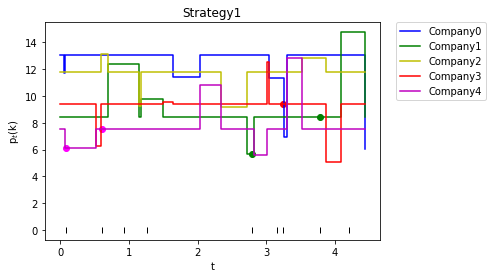

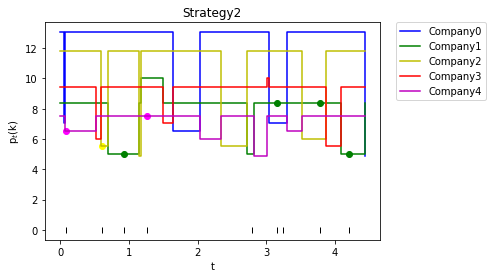

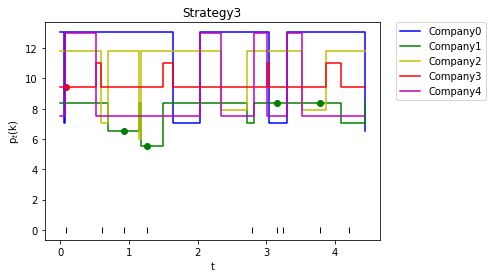

In [10]:
last_time = 4.5
adjustments = [t for t in range(numberPriceAdjustmentsBeforeHorizon[0,0]) if traject_out[0,0,0][t][0][1]<last_time]
colors = ["blue","green","yellow","red","magenta"]
companies = range(numberPlayers)
arrivals = np.concatenate(np.array([arrival_out[0,0][t] for t in adjustments if arrival_out[0,0][t].size]).squeeze())
if arrivals.ndim == 1:
    arrivals = (np.array([arrival_out[0,0][t] for t in adjustments if arrival_out[0,0][t].size]).squeeze())
arrivals = np.array([arrival for arrival in arrivals if arrival[0]<last_time])
for strat in range(len(strategies)):
    plt.step([traject_out[strat,0,0][t][0][1] for t in adjustments], [traject_out[strat,0,0][t][0][0] for t in adjustments], 'b-', label='Company0', where="post")
    plt.step([traject_out[strat,0,0][t][0][1] for t in adjustments], [traject_out[strat,0,0][t][1][0] for t in adjustments], 'g-', label='Company1', where="post")
    plt.step([traject_out[strat,0,0][t][0][1] for t in adjustments], [traject_out[strat,0,0][t][2][0] for t in adjustments], 'y-', label='Company2', where="post")
    plt.step([traject_out[strat,0,0][t][0][1] for t in adjustments], [traject_out[strat,0,0][t][3][0] for t in adjustments], 'r-', label='Company3', where="post")
    plt.step([traject_out[strat,0,0][t][0][1] for t in adjustments], [traject_out[strat,0,0][t][4][0] for t in adjustments], 'm-', label='Company4', where="post")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    buying_data = np.concatenate([x for x in [buying_out[strat,0,0][t] for t in adjustments] if x != []])
    buying_data = np.array([buying for buying in buying_data if buying[0]<last_time])
    for color, company in zip(colors, companies):
        buying_data_comp = np.array([buying_data[x] for x in range(len(buying_data)) if buying_data[x,3]==company])
        if len(buying_data_comp>0):
            plt.scatter(buying_data_comp[:,0] ,buying_data_comp[:,1], c = color)
    plt.plot(arrivals[:,0],[0 for _ in arrivals[:,0]],'k|')
    plt.xlabel('t')
    plt.ylabel('p$_t$(k)')
    plt.title('Strategy{}'.format(strat+1))
    plt.show()
